# Summary



### Preliminaries

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
#     pr_filenames = ['MetricSpace_sinbeta_eta1p5']
#     pr_filenames = ['MetricSpace_sinbeta_eta0p5']
    pr_filenames = ['MetricSpace_sinbeta_eta0p25']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])
    
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import Matrix, Eq, lambdify, poly, numer, denom, \
    simplify, factor, expand, cancel, collect, expand_trig, \
    sin,cos,tan,sec, atan, Rational, sqrt, solve, Abs, N, re, im, det, sign
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot_utils import GraphingBase

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations
# from gme.ode_raytracing import OneRaySolution
from gme.plot import OneRayPlots

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the gme notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from gme package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from gme package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['MetricSpace_sinbeta_eta0p25'])

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rc('font', size=14, family='Arial')

# Theory

## Basics

In [3]:
parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'metricspace',
    'subtitle': '',
    'title': 'Exploration of metric space for sin(beta) erosion model, eta=1/4',
    'verbose': True,
    'very_verbose': False}
{   'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/4,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/8,
    't_xiv0_list': None,
    'varepsilon': 1/100,
    'varphi_0': 20,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.01,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 3

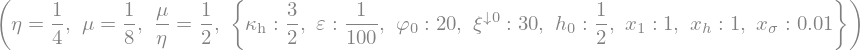

In [4]:
sub = {
        x_1: pr.model.x_1, 
        varepsilon: pr.model.varepsilon, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
        kappa_h: pr.model.kappa_h,
        h_0: pr.model.h_0,
        x_sigma: pr.model.x_sigma,
        x_h: pr.model.x_h
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

In [5]:
def eqns(eqn_list):
    return [getattr(gmeq, eqn) for eqn in eqn_list]

In [6]:
raw_gmeq = Equations( eta=pr.model.eta, do_raw=True,
                      mu=pr.model.mu, 
                      beta_type=pr.model.beta_type, 
                      varphi_type=pr.model.varphi_type, 
                      ibc_type=pr.model.ibc_type,
                      do_idtx=False,
                      do_geodesic=False, 
                      parameters=sub )

In [7]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=False,
                  do_geodesic=False, 
                  parameters=sub )

In [8]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_eta{float(sy.N(gmeq.eta))}'
suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.3f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
                                    else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
# suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
suffix = (suffix if pr.model.varphi_type=='ramp' \
            else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix
job_name

'metricspace_sinbeta_ramp_eta0p25_ratio0p5'

## Metric tensor

In [9]:
pr.model.varphi_0

In [72]:
# varphi_ = 10       # => 1
# varphi_ = 10.5     # => 1
# varphi_ = 10.65    # => 1
# varphi_ = 10.70    # => 1
# varphi_ = 10.72    # => 1
# varphi_ = 10.74    # => 1
# varphi_ = 10.745   # => 1
# varphi_ = 10.746   # => 0
# varphi_ = 10.747   # => 0
# varphi_ = 10.748   # => 0
# varphi_ = 10.75    # => 0
# varphi_ = 11       # => 0
# varphi_ = 12       # => 0

# varphi_ = 10.746
varphi_ = Rational(10746,1000)
N(varphi_)

In [73]:
pz_ = N(gmeq.pz0_xiv0_eqn.rhs.subs({xiv_0:10}))
Eq(pz,pz_)

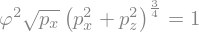

In [74]:
gmeq.pzpx_unity_eqn

In [75]:
if pr.model.eta==Rational(3,2):
    tanbeta_varphi_eqn = (Eq(gmeq.pzpx_unity_eqn.lhs**2,gmeq.pzpx_unity_eqn.rhs**2)
        .subs(e2d(gmeq.px_pz_tanbeta_eqn))
        .subs({pz:pz}))
    tanbeta_varphi_eqn = expand(Eq(varphi**2*numer(tanbeta_varphi_eqn.lhs)- 
                            varphi**2*tanbeta_varphi_eqn.rhs*denom(tanbeta_varphi_eqn.lhs),0))
else:
    tanbeta_varphi_eqn = (Eq(gmeq.pzpx_unity_eqn.lhs**4-1,gmeq.pzpx_unity_eqn.rhs**4-1)
        .subs(e2d(gmeq.px_pz_tanbeta_eqn))
        .subs({pz:pz}))
tanbeta_varphi_eqn

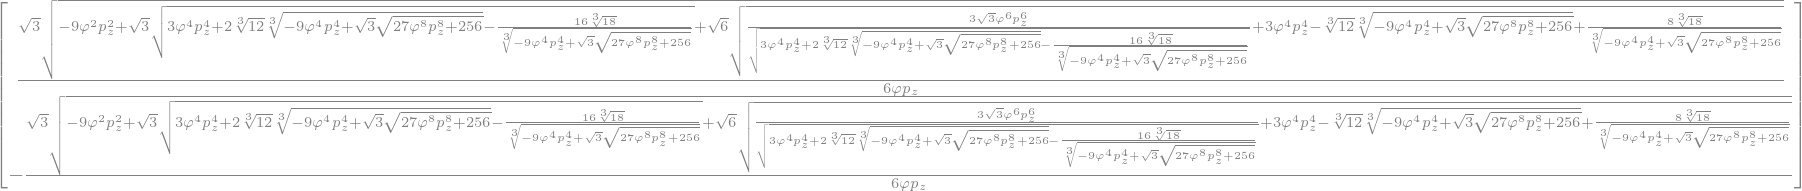

In [76]:
roots = solve(tanbeta_varphi_eqn,tan(beta))
if pr.model.eta==Rational(3,2):
    real_roots = ( factor(roots[0].subs({varphi:varphi}) )), factor( roots[1].subs({varphi:varphi}) )
else:
    real_roots = ( factor(roots[6].subs({varphi:varphi}) )), factor( roots[7].subs({varphi:varphi}) )
Matrix(real_roots)

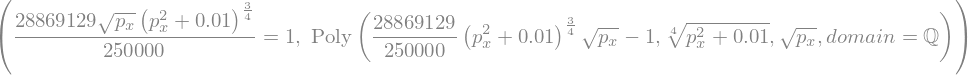

In [77]:
tmp = (gmeq.pzpx_unity_eqn.subs({pz:pz_,varphi:varphi_}))
pzpx_unity_eqn = Eq(tmp.lhs**1, tmp.rhs**1)
pzpx_poly = poly(pzpx_unity_eqn)
pzpx_unity_eqn, pzpx_poly

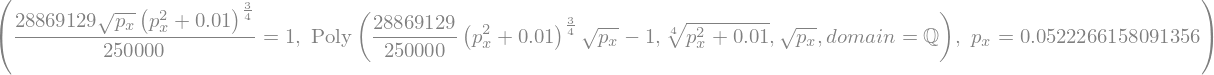

In [78]:
px_ = [N(soln) for soln in solve(pzpx_poly) if im(N(soln))==0 and N(soln)>0][0]
# px_ = [N(soln) for soln in solve(pzpx_unity_eqn) if im(N(soln))==0 and N(soln)>0][0]
pzpx_unity_eqn, pzpx_poly, Eq(px,px_)

In [79]:
# tanbeta_ = sltq.tanbeta_alpha_eqn.rhs.subs({tan(alpha):tanalpha_})
tanbeta_ = gmeq.tanbeta_pxpz_eqn.rhs.subs({px:px_,pz:pz_})
Eq(tan(beta),tanbeta_), 2*tanbeta_**2, np.rad2deg(np.arctan(float(tanbeta_)))

In [80]:
pcovec_lambda = lambdify( (px,pz), 
                          gmeq.p_covec_eqn.rhs.subs({px:px_,pz:pz_}), 
                          modules='sympy' )
pcovec_ = pcovec_lambda(px_,pz_)
Eq(pcovec,pcovec_)

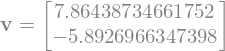

In [81]:
vvec_lambda = lambdify( (px,pz), 
                           Matrix([gmeq.rdotx_pxpz_eqn.rhs.subs({varphi_r:varphi_}),
                                   gmeq.rdotz_pxpz_eqn.rhs.subs({varphi_r:varphi_})]),
                           modules='sympy' )
vvec_ = vvec_lambda(px_,pz_)
# , rdotvec_lambda(0.0188052295947738,-0.0666666666666667)
Eq(rdotvec,vvec_)

In [82]:
raw_gmeq.define_tanbeta_eqns()

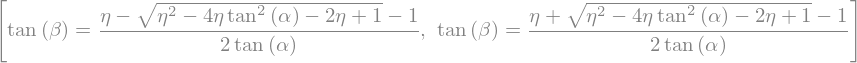

In [83]:
raw_gmeq.tanbeta_alpha_eqns

In [84]:
raw_gmeq.tanbeta_alpha_eqns[1].subs({tan(alpha):-0.001, eta:Rational(1,2)})

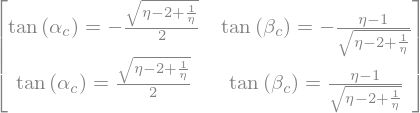

In [85]:
Matrix([raw_gmeq.tanalpha_crit_eqns, raw_gmeq.tanbeta_crit_eqns]).T

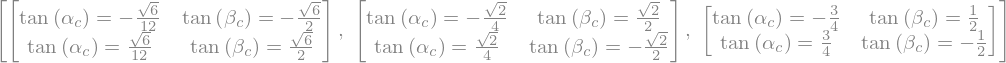

In [86]:
[Matrix([[eqn_.subs({eta:eta_}) for eqn_ in raw_gmeq.tanalpha_crit_eqns], 
         [eqn_.subs({eta:eta_}) for eqn_ in raw_gmeq.tanbeta_crit_eqns]]).T 
 for eta_ in [Rational(3,2),Rational(1,2),Rational(1,4)]]

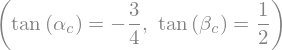

In [87]:
raw_gmeq.tanalpha_crit_eqn.subs({eta:pr.model.eta}), raw_gmeq.tanbeta_crit_eqn.subs({eta:pr.model.eta})

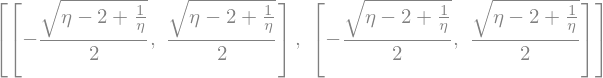

In [88]:
tanalpha_critical_solns = [solve(Eq(-numer((raw_gmeq.tanbeta_alpha_eqns[idx]).rhs)+(eta-1),0),tan(alpha)) for idx in [0,1]]
tanalpha_critical_solns

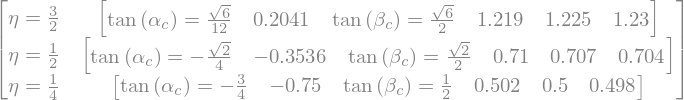

In [89]:
Matrix([(
    Eq(eta,eta_),
    Matrix([
    ([ Matrix([Eq(tan(alpha_crit),soln.subs({eta:eta_})), round(N(soln.subs({eta:eta_})),4)]).T,
        Matrix([raw_gmeq.tanbeta_alpha_eqn.subs({beta:beta_crit, eta:eta_, tan(alpha):soln.subs({eta:eta_})}),
        round(raw_gmeq.tanbeta_alpha_eqns[0].rhs.subs({eta:eta_, tan(alpha):soln.subs({eta:eta_})*0.99999}),3),
        round(raw_gmeq.tanbeta_alpha_eqns[0].rhs.subs({eta:eta_, tan(alpha):soln.subs({eta:eta_})*1}),3),
        round(raw_gmeq.tanbeta_alpha_eqns[1].rhs.subs({eta:eta_, tan(alpha):soln.subs({eta:eta_})*0.99999}),3) ]).T
        ]) for soln in [tanalpha_critical_solns[0][1] if eta_==Rational(3,2) else tanalpha_critical_solns[0][0]] ])
) for eta_ in [Rational(3,2),Rational(1,2),Rational(1,4)] ])

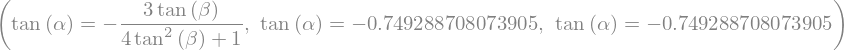

In [90]:
tanalpha_ = gmeq.tanalpha_beta_eqn.rhs.subs({tan(beta):tanbeta_})
gmeq.tanalpha_beta_eqn, Eq(tan(alpha),tanalpha_), Eq(tan(alpha),vvec_[1]/vvec_[0])

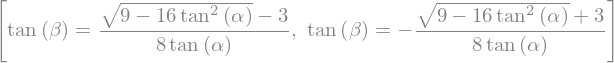

In [91]:
tanalpha_lambda = lambdify( (beta), gmeq.tanalpha_beta_eqn.rhs, modules='sympy' )
tanbeta_alpha_eqns = [Eq(tan(beta), soln.subs({ta:tan(alpha)}))
                         for soln in (sy.solve(gmeq.tanalpha_beta_eqn.subs({tan(alpha):ta}),tan(beta)))]
tanbeta_alpha_eqns

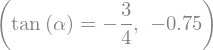

In [92]:
[(Eq(tan(alpha), (soln)),N(soln)) 
     for soln in solve(Eq(tanbeta_alpha_eqns[0].rhs, tanbeta_alpha_eqns[1].rhs), tan(alpha))
        if sign(soln)==sign(tanalpha_)][0]

In [93]:
[tanbeta_alpha_eqn.subs({tan(alpha):tanalpha_}) for tanbeta_alpha_eqn in tanbeta_alpha_eqns]

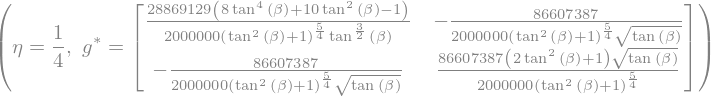

In [94]:
if pr.model.eta == Rational(3,2):
    gstar_tanbeta_eqn = (expand_trig(simplify( 
            gmeq.gstar_varphi_pxpz_eqn
                .subs({varphi_r:varphi_})
                .subs(e2d(gmeq.px_pz_tanbeta_eqn))
        )).subs({Abs(cos(beta)):cos(beta)})
        .subs({sin(beta):sqrt(1-cos(beta)**2)})
        .subs({cos(beta):1/sqrt(1+tan(beta)**2)}) )
elif pr.model.eta == Rational(1,2):
    gstar_tanbeta_eqn = factor(factor(factor( gmeq.gstar_varphi_pxpz_eqn
            .subs({varphi_r:varphi_})
            .subs(e2d(gmeq.px_pz_tanbeta_eqn))
                                        ))
            .subs({Abs(cos(beta)):cos(beta)})
            .subs({cos(beta):1/sqrt(1+tan(beta)**2)}) )
else:
    gstar_tanbeta_eqn = (simplify(factor( gmeq.gstar_varphi_pxpz_eqn
            .subs({varphi_r:varphi_})
            .subs(e2d(gmeq.px_pz_tanbeta_eqn))
                                        ))
            .subs({Abs(cos(beta)):cos(beta)})
            .subs({cos(beta):1/sqrt(1+tan(beta)**2)}) )
Eq(eta,pr.model.eta), gstar_tanbeta_eqn

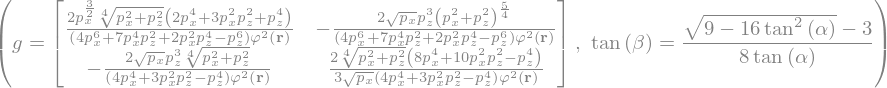

In [95]:
gmeq.g_varphi_pxpz_eqn, gmeq.tanbeta_alpha_eqn

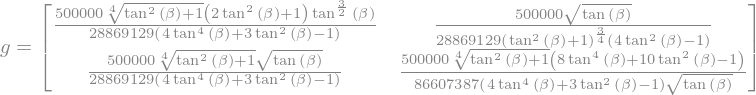

In [96]:
g_tanbeta_eqn = (simplify(factor( gmeq.g_varphi_pxpz_eqn
        .subs({varphi_r:varphi_})
        .subs(e2d(gmeq.px_pz_tanbeta_eqn)) ))
        .subs({Abs(cos(beta)):cos(beta)})
        .subs({cos(beta):1/sqrt(1+tan(beta)**2)}) )
g_tanbeta_eqn

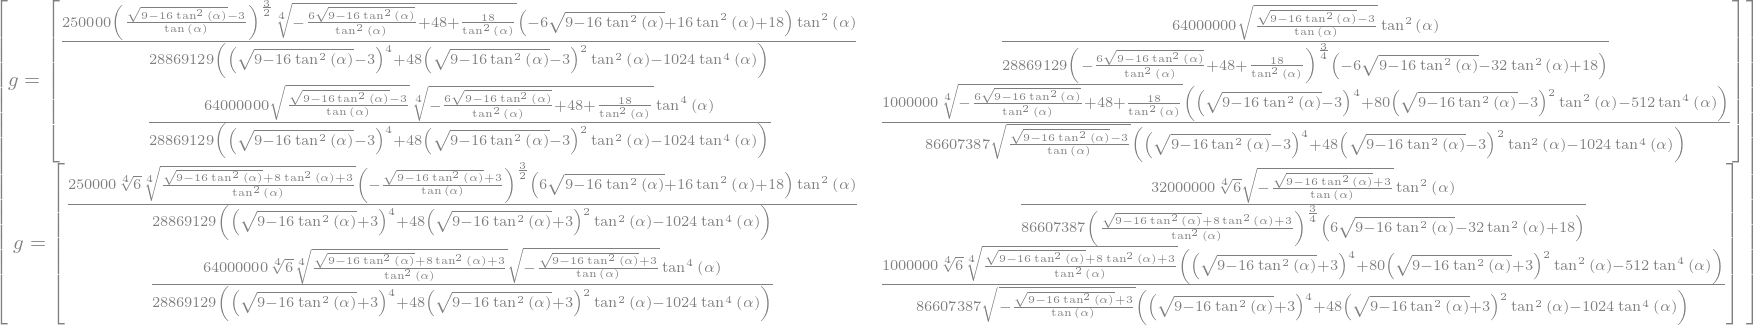

In [97]:
g_tanalpha_eqns = [Eq(g, simplify( g_tanbeta_eqn.rhs.subs(e2d(tanbeta_alpha_eqn)) ))
                  for tanbeta_alpha_eqn in tanbeta_alpha_eqns]
Matrix(g_tanalpha_eqns)

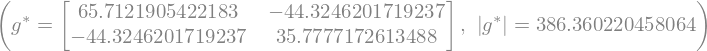

In [98]:
gstar_tanbeta_ = gstar_tanbeta_eqn.rhs.subs({tan(beta):tanbeta_})
Eq(gstar,gstar_tanbeta_), Eq(det(gstar),det(gstar_tanbeta_))

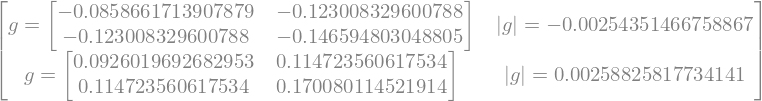

In [99]:
g_tanalpha_list = [N(g_tanalpha_eqn.rhs.subs({(tan(alpha)):tanalpha_})) for g_tanalpha_eqn in g_tanalpha_eqns]
Matrix([(Eq(g,g_tanalpha_), Eq(det(g), det(g_tanalpha_))) for g_tanalpha_ in g_tanalpha_list])

In [100]:
unitvec = lambda alpha: N(Matrix([cos(alpha),sin(alpha)]).T)
get_eigenvalues = lambda evs: [ev[0] for ev in evs]
get_eigenvectors = lambda evs: [ev[2][0] for ev in evs]
get_eigentanangles = lambda evs: [ev[2][0][1]/ev[2][0][0] for ev in evs]

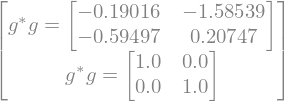

In [101]:
Matrix([Eq(gstar*g, (gstar_tanbeta_*g_tanalpha_).applyfunc(lambda x: round(x,5))) for g_tanalpha_ in g_tanalpha_list])

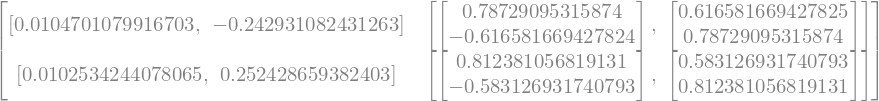

In [102]:
evs_list = [g_tanalpha_.eigenvects() for g_tanalpha_ in g_tanalpha_list]
Matrix([(get_eigenvalues(evs), get_eigenvectors(evs)) for evs in evs_list])

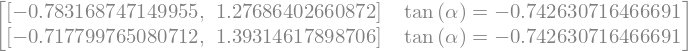

In [103]:
Matrix([(get_eigentanangles(evs), Eq(tan(alpha),tanalpha_lambda(-px_/pz_))) for evs in evs_list])

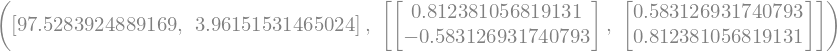

In [104]:
evs = gstar_tanbeta_.eigenvects()
get_eigenvalues(evs), get_eigenvectors(evs)

In [105]:
get_eigentanangles(evs), Eq(tan(beta),-px_/pz_)

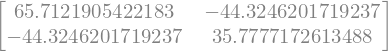

In [106]:
gstar_lambda = lambdify( (px,pz),
                         gmeq.gstar_varphi_pxpz_eqn.rhs.subs({varphi_r:varphi_}),
                         modules='sympy' )
gstar_lambda(px_,pz_)

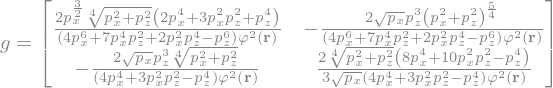

In [107]:
gmeq.g_varphi_pxpz_eqn

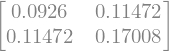

In [108]:
g_lambda = lambdify( (px,pz),
                     gmeq.g_varphi_pxpz_eqn.rhs.subs({varphi_r:varphi_}),
                     modules='sympy' )
g_lambda(px_,pz_).applyfunc(lambda x: round(x,5))

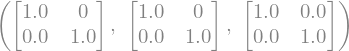

In [109]:
(
    (g_lambda(px_/1.3,pz_)*gstar_lambda(px_/1.3,pz_)).applyfunc(lambda x: round(x,5)),
    (g_lambda(px_*1.0,pz_)*gstar_lambda(px_*1.0,pz_)).applyfunc(lambda x: round(x,5)),
    (g_lambda(px_*1.3,pz_)*gstar_lambda(px_*1.3,pz_)).applyfunc(lambda x: round(x,5))
)

In [110]:
Eq(pcovec,pcovec_), Eq(pcovec,(g_lambda(px_,pz_)*vvec_).T)

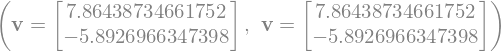

In [111]:
Eq(rdotvec,vvec_), Eq(rdotvec,(pcovec_*gstar_lambda(px_,pz_)).T)

In [112]:
pcovec_.dot(vvec_)

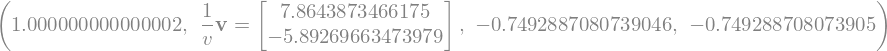

In [113]:
gvv_ = float((vvec_lambda(px_,pz_).T*g_lambda(px_,pz_)*vvec_lambda(px_,pz_))[0])
gvv_, Eq(rdotvec/rdot,vvec_/gvv_), float(vvec_[1]/vvec_[0]), tanalpha_

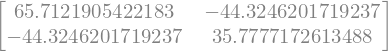

In [114]:
gstar_tanbeta_

In [115]:
gstarpp_ = float((pcovec_lambda(px_,pz_)*gstar_lambda(px_,pz_)*pcovec_lambda(px_,pz_).T)[0])
gstarpp_

In [116]:
npx_ = float(px_)
if pr.model.eta == Rational(3,2):
    px_gvv_array = np.linspace(npx_/1.2,npx_*1.2)
    px_gstarpp_array = np.linspace(npx_/1.15,npx_*1.35)
else:
    px_gvv_array = np.linspace(npx_/1.2,npx_*1.2)
    px_gstarpp_array = np.linspace(npx_/1.2,npx_*1.2)
    
tanbeta_gvv_array = -px_gvv_array/pz_
tanbeta_gstarpp_array = -px_gstarpp_array/pz_
# These are not "correct" calculations of tan(alpha)...
tanalpha_gvv_array = np.array([tanalpha_lambda(tanbeta__) for tanbeta__ in tanbeta_gvv_array])

vx_array = np.array( [float((vvec_lambda(px__,pz_))[0]) for px__ in px_gvv_array] )
vz_array = np.array( [float((vvec_lambda(px__,pz_))[1]) for px__ in px_gvv_array] )
# ... but these *are* correct
tanalpha_vzvx_array = vz_array/vx_array
tanalpha_gvv_array,tanalpha_vzvx_array;

In [117]:
gvv_array = np.array( 
    [float((vvec_lambda(px__,pz_).T*g_lambda(px__,pz_)*vvec_lambda(px__,pz_))[0]) 
                         for px__ in px_gvv_array] )
vvec_list = [((pcovec_lambda(px__,pz_)*gstar_lambda(px__,pz_)))
                     for px__ in px_gvv_array]
vvec_array = np.stack([
    np.array([float(vvc[0]) for vvc in vvec_list]),
    np.array([float(vvc[1]) for vvc in vvec_list])
]).T

In [118]:
gstarpp_array = np.array( 
    [float((pcovec_lambda(px__,pz_)*gstar_lambda(px__,pz_)*pcovec_lambda(px__,pz_).T)[0]) 
                         for px__ in px_gstarpp_array] )
pcovec_list = [((g_lambda(px__,pz_)*vvec_lambda(px__,pz_)))
                     for px__ in px_gvv_array]
pcovec_array = np.stack([
    np.array([float(pcvc[0]) for pcvc in pcovec_list]),
    np.array([float(pcvc[1]) for pcvc in pcovec_list])
]).T

In [119]:
(
    pcovec_lambda(px_gvv_array[0],pz_)*vvec_lambda(px_gvv_array[0],pz_),
    pcovec_lambda(px_,pz_)*vvec_lambda(px_,pz_),
    pcovec_lambda(px_gvv_array[-1],pz_)*vvec_lambda(px_gvv_array[-1],pz_),    
)

In [120]:
(
    vvec_lambda(px_gvv_array[0],pz_)[0], 
    (pcovec_lambda(px_gvv_array[0],pz_)*gstar_lambda(px_gvv_array[0],pz_))[0], 
    vvec_array[0,0], vx_array[0]
)

In [121]:
# pdotv_array = np.array( [np.dot(p_,v_) for v_,p_ in zip(vvec_array,pcovec_array)] )
# np.stack([ pdotv_array, gvv_array, gstarpp_array ]).T

## Visualizations

In [59]:
gr = GraphingBase()

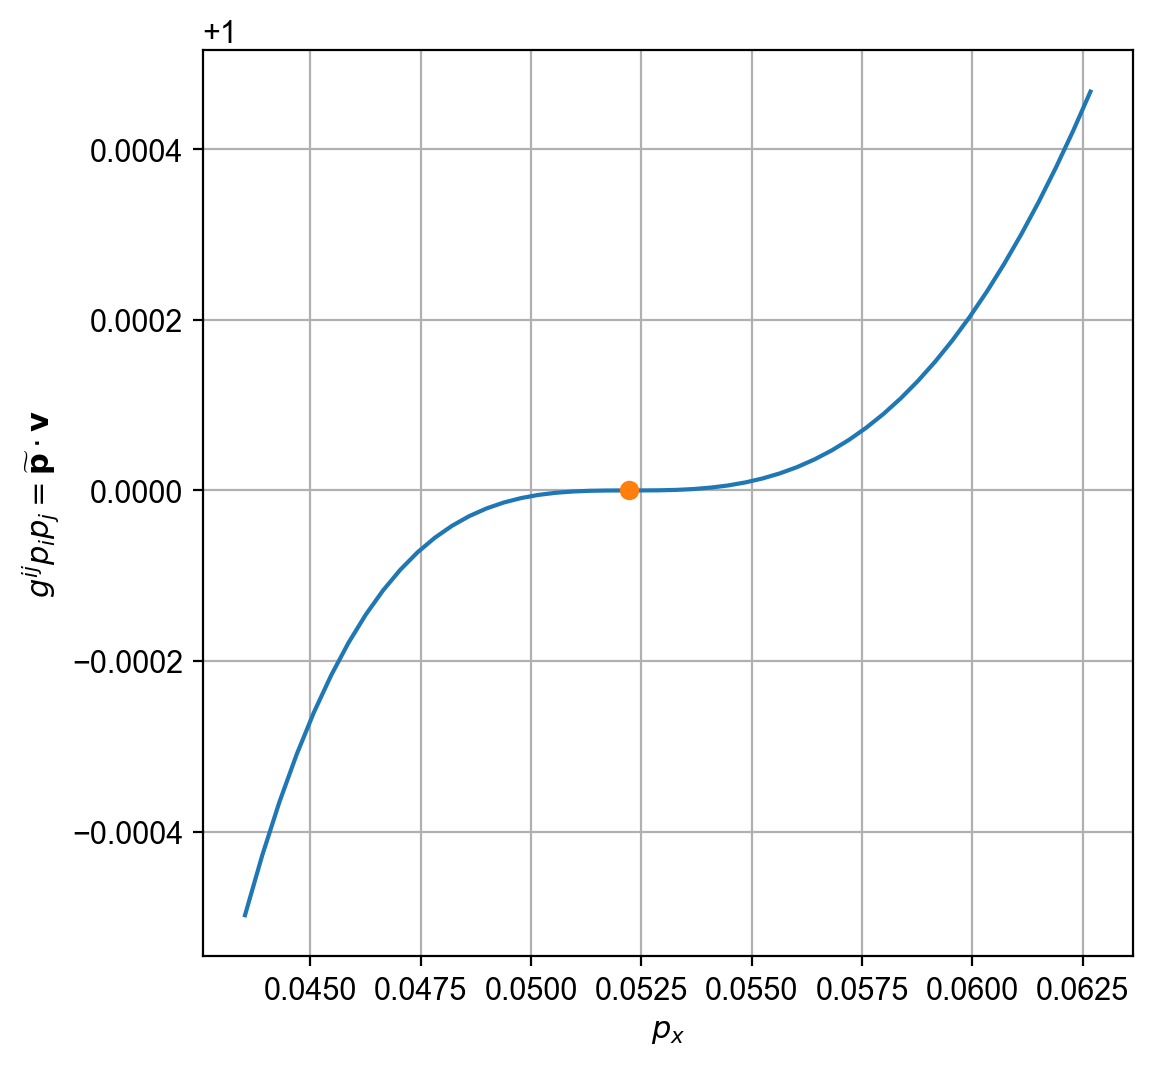

In [60]:
fig = gr.create_figure(job_name+'_pdotv_px', fig_size=(6,6))
plt.plot(px_gstarpp_array, gstarpp_array)
plt.plot(px_, gstarpp_, 'o')
plt.grid('on')
plt.ylabel(r'$g^{ij} p_i p_j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$p_x$');

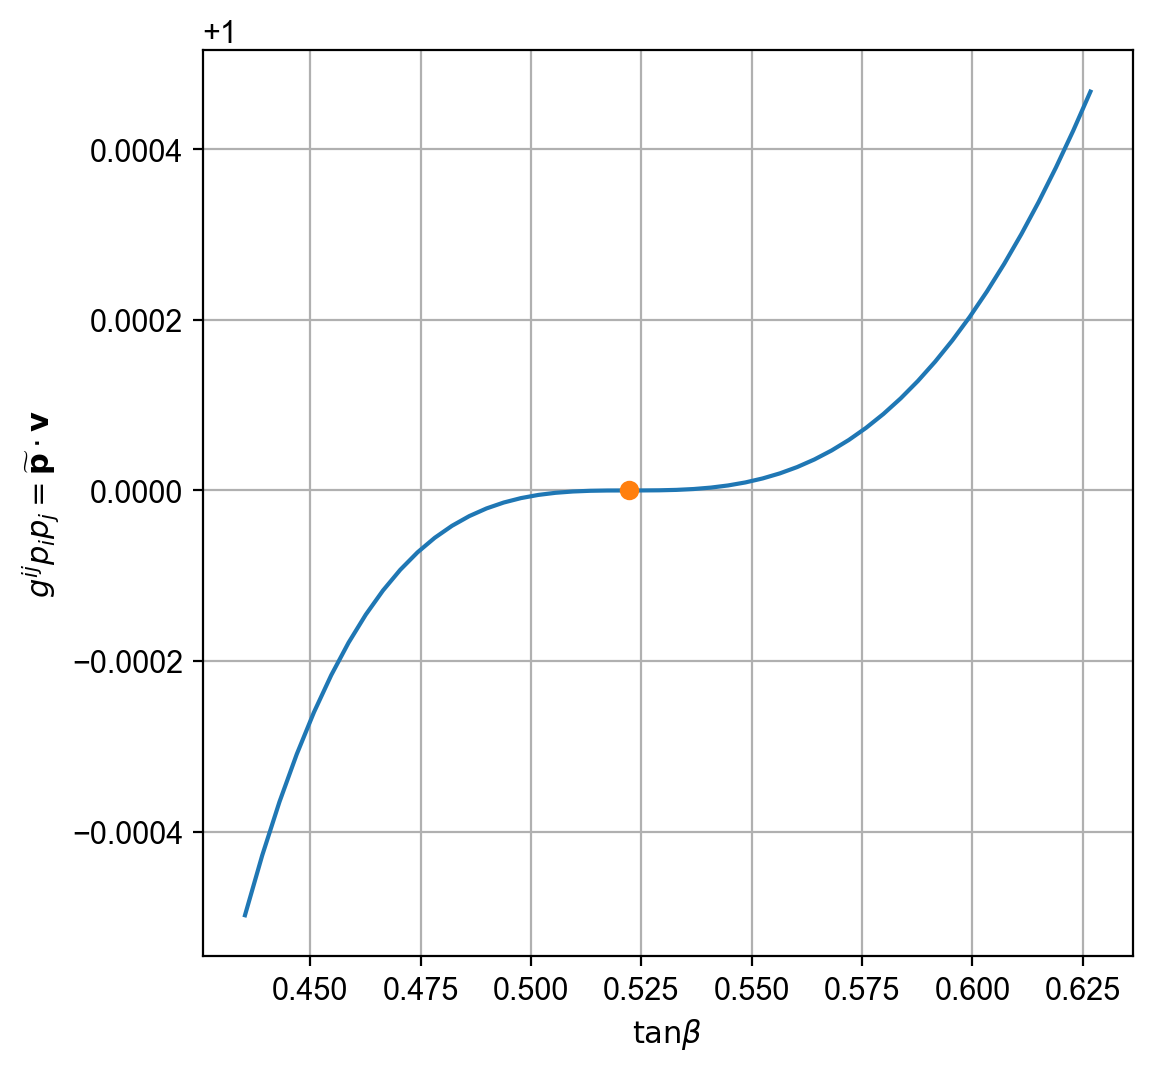

In [61]:
fig = gr.create_figure(job_name+'_pdotv_tanbeta', fig_size=(6,6))
plt.plot(tanbeta_gstarpp_array, gstarpp_array)
plt.plot(-px_/pz_, gstarpp_, 'o')
plt.grid('on')
plt.ylabel(r'$g^{ij} p_i p_j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$\tan\beta$');

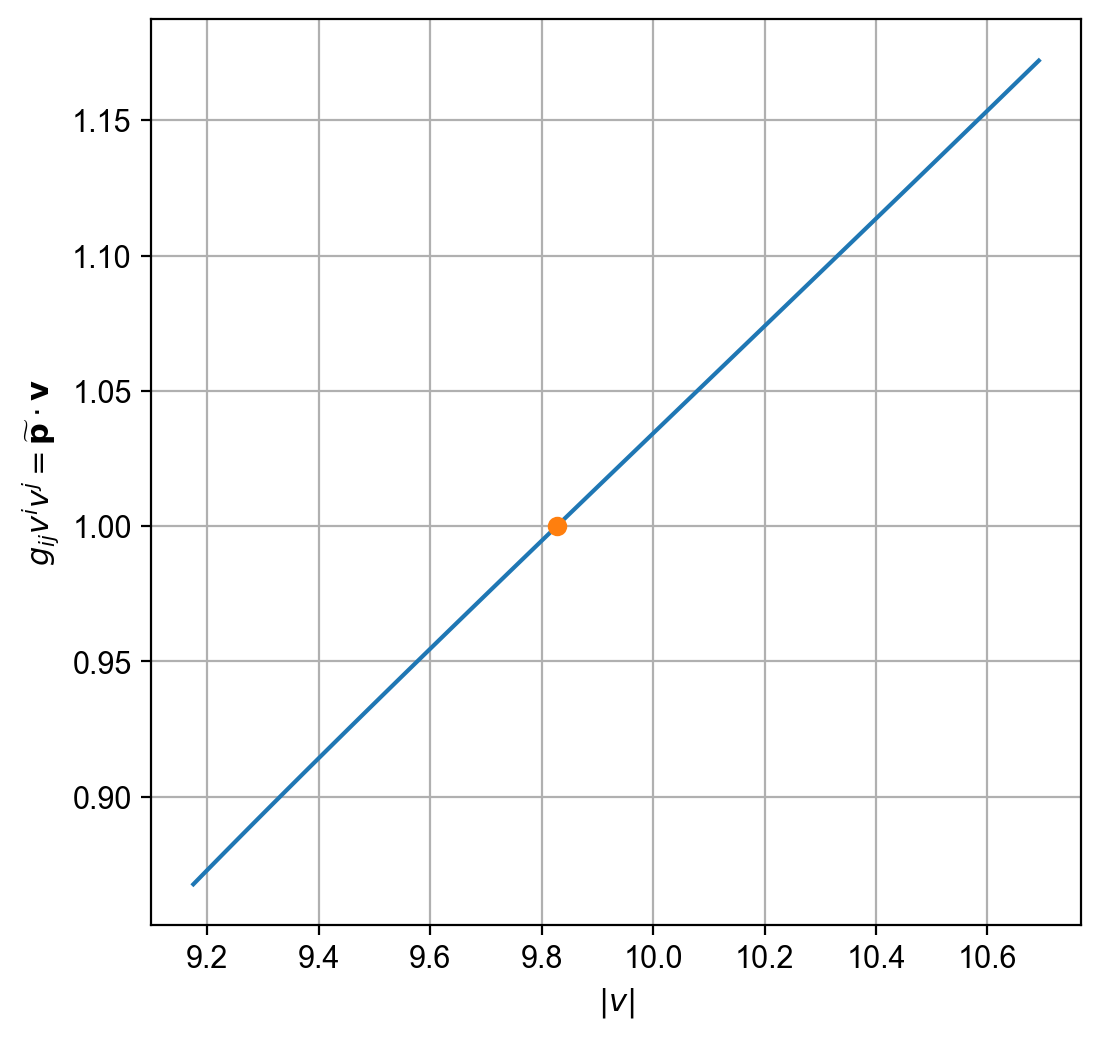

In [62]:
fig = gr.create_figure(job_name+'_pdotv_modv', fig_size=(6,6))
plt.plot(np.sqrt(vx_array**2+vz_array**2), gvv_array)
vvec_ = vvec_lambda(px_,pz_)
plt.plot(np.sqrt(float(vvec_[0])**2+float(vvec_[1])**2), gvv_, 'o')
plt.grid('on')
plt.ylabel(r'$g_{ij} v^i v^j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$|v|$');

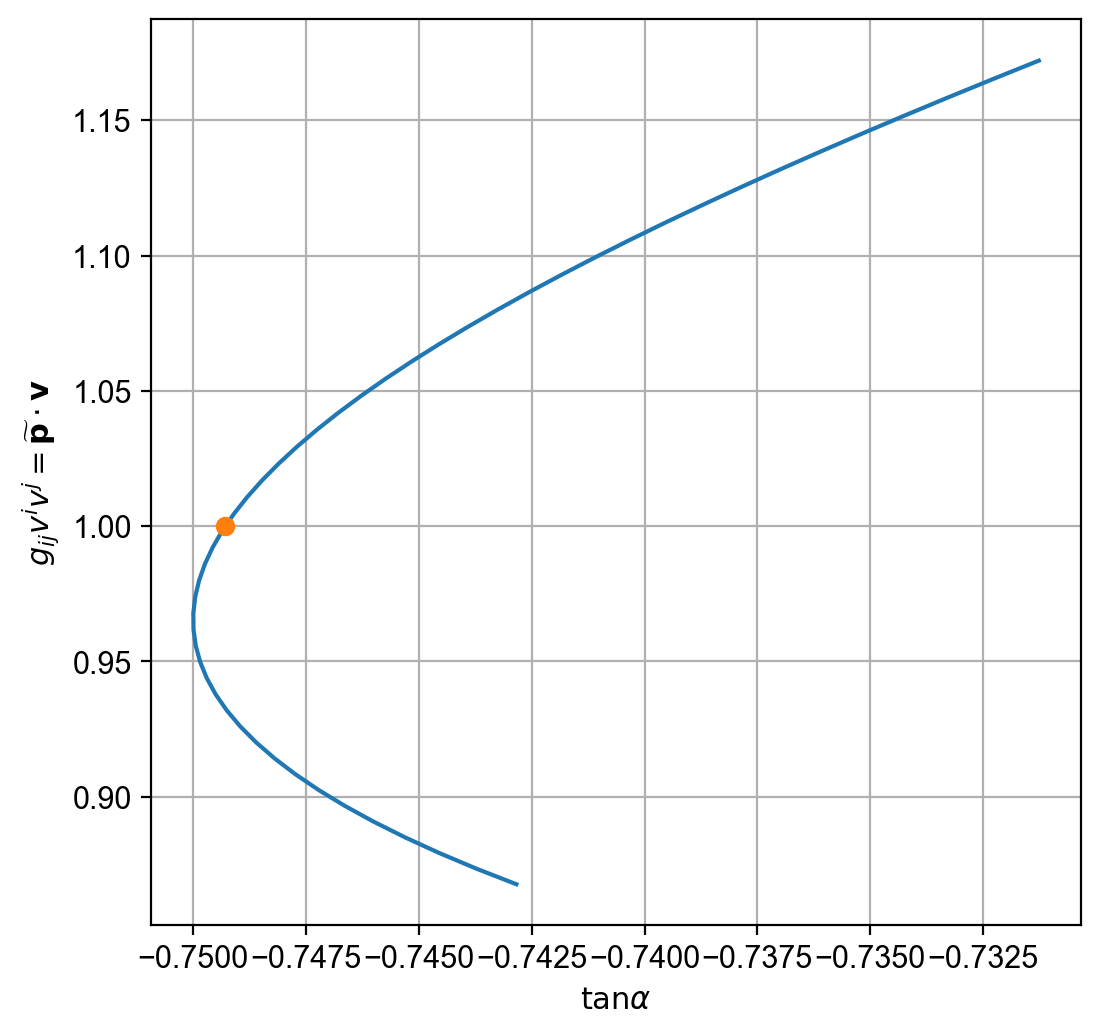

In [63]:
fig = gr.create_figure(job_name+'_pdotv_tanalpha', fig_size=(6,6))
plt.plot(tanalpha_vzvx_array, gvv_array)
plt.plot(tanalpha_, gvv_, 'o')
plt.grid('on')
plt.ylabel(r'$g_{ij} v^i v^j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$\tan\alpha$');

# Save

Export the graphs as PNG and/or PDF image files.

In [64]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/Theory"
Exported "metricspace_sinbeta_ramp_eta0p25_ratio0p5_pdotv_px.png"
Exported "metricspace_sinbeta_ramp_eta0p25_ratio0p5_pdotv_tanbeta.png"
Exported "metricspace_sinbeta_ramp_eta0p25_ratio0p5_pdotv_modv.png"
Exported "metricspace_sinbeta_ramp_eta0p25_ratio0p5_pdotv_tanalpha.png"
